In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

%pip install lightgbm
%pip install --only-binary=:all: xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
# ==========================================
# 1. LOAD DATA & SPLIT
# ==========================================
print("Loading the Top-200 features dataset...")
df = pd.read_csv('vodafone_age_top200_sprint2.csv')

X = df.drop(columns=['target'])
y_raw = df['target']

# For XGBoost
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Train / Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Loading the Top-200 features dataset...
Training set shape: (50400, 200)
Test set shape: (12600, 200)


In [3]:
# ==========================================
# 2. PIPELINES SETUP (7 Models for Testing)
# ==========================================
# We wrap each model in a Pipeline with StandardScaler to ensure fair comparison
pipelines = {
    "kNN": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
    ]),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ]),
    "Decision Tree": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ('scaler', StandardScaler()),
        # GradientBoostingClassifier does not support n_jobs=-1 natively
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42)) 
    ]),
    "LightGBM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))
    ]),
    "XGBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'))
    ])
}

results = []
best_model_name = "" 
best_y_pred = None
best_f1_score = 0.0

In [4]:
# ==========================================
# 3. TRAINING & AUTOMATIC BEST MODEL SELECTION
# ==========================================
print("\nStarting multi-model training and overfitting analysis...\n")

for name, pipeline in pipelines.items():
    print(f"Currently training: {name}...")
    start_time = time.time()
    
    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)
    
    # Generate predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Execution time calculation
    exec_time = time.time() - start_time
    
    # Calculate Metrics
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Finding best model
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        best_model_name = name
        best_y_pred = y_test_pred
    
    # Overfit Gap
    overfit_gap = train_f1 - test_f1
    
    results.append({
        "Model": name,
        "Train F1 (W)": train_f1,
        "Test F1 (W)": test_f1,
        "Overfit Gap": overfit_gap,
        "Test Accuracy": test_acc,
        "Time (s)": round(exec_time, 2)
    })

print(f"\n🏆 Automatic selection complete! The best model is: {best_model_name} with F1-Score: {best_f1_score:.4f}")


Starting multi-model training and overfitting analysis...

Currently training: kNN...
Currently training: Logistic Regression...
Currently training: Decision Tree...
Currently training: Random Forest...
Currently training: Gradient Boosting...
Currently training: LightGBM...


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Currently training: XGBoost...

🏆 Automatic selection complete! The best model is: LightGBM with F1-Score: 0.4635



=== MODEL PERFORMANCE COMPARISON ===
              Model  Train F1 (W)  Test F1 (W)  Overfit Gap  Test Accuracy  Time (s)
           LightGBM      0.632928     0.463485     0.169443       0.464286     11.53
            XGBoost      0.699815     0.457451     0.242364       0.457937     15.23
  Gradient Boosting      0.493015     0.452913     0.040102       0.454127    407.07
      Random Forest      0.999881     0.444842     0.555039       0.447460     13.52
Logistic Regression      0.426351     0.412395     0.013956       0.416508      9.92
                kNN      0.561397     0.341085     0.220311       0.341825     22.73
      Decision Tree      0.999881     0.339191     0.660690       0.339365      5.57


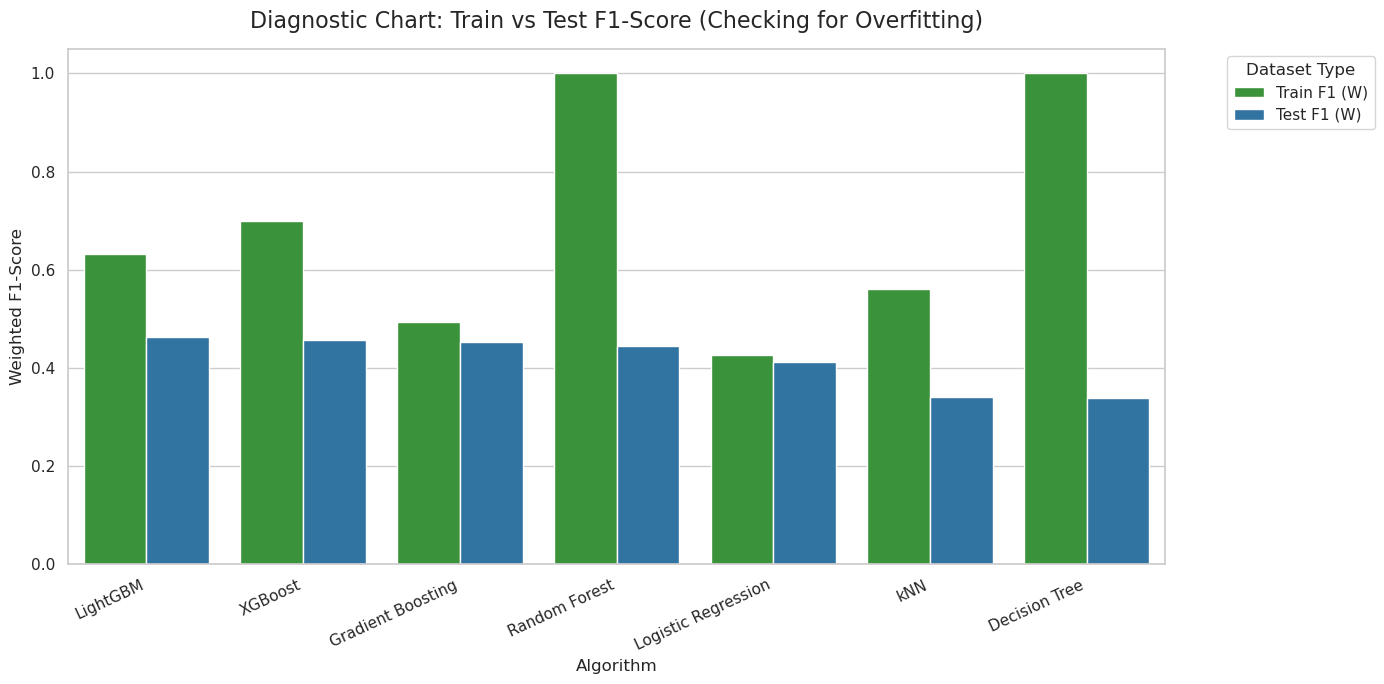


=== DETAILED CLASSIFICATION REPORT: LightGBM ===
              precision    recall  f1-score   support

           1       0.53      0.31      0.39       320
           2       0.49      0.43      0.46       656
           3       0.44      0.42      0.43      2406
           4       0.44      0.42      0.43      3643
           5       0.45      0.54      0.49      3622
           6       0.57      0.49      0.53      1953

    accuracy                           0.46     12600
   macro avg       0.49      0.44      0.46     12600
weighted avg       0.47      0.46      0.46     12600



In [5]:
# ==========================================
# 4. RESULTS VISUALIZATION
# ==========================================
# Create a summary dataframe sorted by Test F1 Score
results_df = pd.DataFrame(results).sort_values(by="Test F1 (W)", ascending=False)
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df.to_string(index=False))

# Visualization: Train vs Test F1-Score (Overfitting Diagnosis)
plt.figure(figsize=(14, 7))

# Reshape data for plotting with Seaborn
plot_df = results_df[['Model', 'Train F1 (W)', 'Test F1 (W)']].melt(
    id_vars='Model', var_name='Dataset', value_name='F1 Score'
)

sns.barplot(data=plot_df, x='Model', y='F1 Score', hue='Dataset', palette=['#2ca02c', '#1f77b4'])
plt.title('Diagnostic Chart: Train vs Test F1-Score (Checking for Overfitting)', fontsize=16, pad=15)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Weighted F1-Score', fontsize=12)
plt.xticks(rotation=25, ha='right', fontsize=11)
plt.legend(title='Dataset Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Inverse transform classes back to 1-6 for the final report
y_test_orig = le.inverse_transform(y_test)
best_y_pred_orig = le.inverse_transform(best_y_pred)

print(f"\n=== DETAILED CLASSIFICATION REPORT: {best_model_name} ===")
print(classification_report(y_test_orig, best_y_pred_orig, zero_division=0))